# Plot qPCR of RNA export by candidate nanocage-based exporters

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_EPN_screen"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_EPN_screen_Cq_plate1.csv"

cq_raw_plate1 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate1.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate1.set_index("Well", inplace=True)

print(cq_raw_plate1.shape)
cq_raw_plate1.head()

(95, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well 1,Supernatant,33.689173,33.783310,1.624268,490.451652,2.690596,576.064276,424.196139
A02,SYBR,mCherry,Unkn-02,Well 2,Supernatant,32.540446,32.053766,0.432784,876.331793,2.942669,1137.983873,235.180080
A03,SYBR,mCherry,Unkn-03,Well 3,Supernatant,33.080781,32.602999,0.615836,666.959429,2.824099,878.019544,288.139762
A04,SYBR,mCherry,Unkn-04,Well 4,Supernatant,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
A05,SYBR,mCherry,Unkn-05,Well 5,Supernatant,32.284271,32.184595,0.466571,997.430264,2.998883,1068.942143,258.962363


In [5]:
infile = "../preprocessed_data/qPCR_data/qPCR_EPN_screen_Cq_plate2.csv"

cq_raw_plate2 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate2.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate2.set_index("Well", inplace=True)

print(cq_raw_plate2.shape)
cq_raw_plate2.head()

(48, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well 21,Supernatant,23.341466,23.174017,0.147296,99097.383750,4.996062,107865.636131,7728.343031
A02,SYBR,mCherry,Unkn-02,Well 22,Supernatant,30.623508,30.646042,0.404567,2678.853374,3.427949,2684.543417,531.392712
A03,SYBR,mCherry,Unkn-03,Well 23,Supernatant,31.007127,31.006107,0.075361,2214.830987,3.345341,2216.983704,82.858485
A04,SYBR,mCherry,Unkn-04,Well 24,Supernatant,29.893101,29.978916,0.253938,3847.997080,3.585235,3706.844477,452.523892
A05,SYBR,mCherry,Unkn-05,Well 25,Supernatant,25.455218,25.309239,0.186021,34744.593203,4.540887,37460.201741,3522.561493


## Load metadata

In [6]:
# Load metadata (includes sample inputs and volumes for calculating total molecule abundance)
infile = "../preprocessed_data/qPCR_data/qPCR_EPN_screen_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(28, 12)


,Sample,Biological Set Name,cells,exporter,condition,description,simple_description,xticklabel,xticklabel_simple,color,legend_label,export_tag_plus_or_minus
0,Well1,Supernatant,cFH16 (mCh-MS2x8),pFH2.96-EPN1,NaN,EPN1 + mCh-MS2x8,EPN1,EPN1 + mCh-MS2x8,EPN1,#969696,No RBD,+
1,Well2,Supernatant,cFH15 (mCh),pFH2.96-EPN1,NaN,EPN1 + mCh,EPN1,EPN1 + mCh,EPN1,#bdbdbd,No RBD and no packaging signal,-
2,Well3,Supernatant,cFH16 (mCh-MS2x8),pFH2.97-EPN1-MCP,NaN,EPN1-MCP + mCh-MS2x8,EPN1-MCP,EPN1-MCP + mCh-MS2x8,EPN1-MCP,#807dba,Exporter and packaging signal,+
3,Well4,Supernatant,cFH15 (mCh),pFH2.97-EPN1-MCP,NaN,EPN1-MCP + mCh,EPN1-MCP,EPN1-MCP + mCh,EPN1-MCP,#41ab5d,No packaging signal,-
4,Well5,Supernatant,cFH16 (mCh-MS2x8),pFH2.98-EPN1-MCP_Myc,NaN,EPN1-MCP_Myc + mCh-MS2x8,EPN1-MCP_Myc,EPN1-MCP_Myc + mCh-MS2x8,EPN1-MCP_Myc,#807dba,Exporter and packaging signal,+


## Set sample labels and colors

In [7]:
# Set tick labels
column_to_xticklabel = {"Well1": "EPN1 + mCherry-MS2x8", 
                        "Well2": "EPN1 + mCherry",
                        "Well3": "EPN1-MCP + mCherry-MS2x8", 
                        "Well4": "EPN1-MCP + mCherry",
                        "Well5": "EPN1-MCP_Myc + mCherry-MS2x8", 
                        "Well6": "EPN1-MCP_Myc + mCherry",
                        "Well7": "EPN1-MCP_I + mCherry-MS2x8",
                        "Well8": "EPN1-MCP_I + mCherry",
                        "Well9": "EPN11 + mCherry-MS2x8", 
                        "Well10": "EPN11 + mCherry",
                        "Well11": "EPN11-MCP + mCherry-MS2x8", 
                        "Well12": "EPN11-MCP + mCherry",
                        "Well13": "EPN11-MCP_I + mCherry-MS2x8", 
                        "Well14": "EPN11-MCP_I + mCherry",
                        "Well15": "EPN11-MCP_p6 + mCherry-MS2x8",
                        "Well16": "EPN11-MCP_p6 + mCherry",
                        "Well17": "EPN24 + mCherry-MS2x8", 
                        "Well18": "EPN24 + mCherry",
                        "Well19": "EPN24-MCP + mCherry-MS2x8", 
                        "Well20": "EPN24-MCP + mCherry",
                        "Well21": "EPN24-MCP_I + mCherry-MS2x8", 
                        "Well22": "EPN24-MCP_I + mCherry",
                        "Well23": "EPN24-MCP_p6 + mCherry-MS2x8",
                        "Well24": "EPN24-MCP_p6 + mCherry",
                        "Well25": "Gag-MCP + mCherry-MS2x8", 
                        "Well26": "Gag-MCP + mCherry",
                        "Well27": "mCherry-MS2x8", 
                        "Well28": "mCherry"}

In [8]:
# Set exporters
column_to_exporter = {"Well1": "EPN1", 
                        "Well2": "EPN1",
                        "Well3": "EPN1-MCP", 
                        "Well4": "EPN1-MCP",
                        "Well5": "EPN1-MCP_Myc", 
                        "Well6": "EPN1-MCP_Myc",
                        "Well7": "EPN1-MCP_I",
                        "Well8": "EPN1-MCP_I",
                        "Well9": "EPN11", 
                        "Well10": "EPN11",
                        "Well11": "EPN11-MCP", 
                        "Well12": "EPN11-MCP",
                        "Well13": "EPN11-MCP_I", 
                        "Well14": "EPN11-MCP_I",
                        "Well15": "EPN11-MCP_p6",
                        "Well16": "EPN11-MCP_p6",
                        "Well17": "EPN24", 
                        "Well18": "EPN24",
                        "Well19": "EPN24-MCP", 
                        "Well20": "EPN24-MCP",
                        "Well21": "EPN24-MCP_I", 
                        "Well22": "EPN24-MCP_I",
                        "Well23": "EPN24-MCP_p6",
                        "Well24": "EPN24-MCP_p6",
                        "Well25": "Gag-MCP", 
                        "Well26": "Gag-MCP",
                        "Well27": "None", 
                        "Well28": "None"}

In [9]:
# Set reporters
column_to_reporter = {"Well1": "mCherry-MS2x8", 
                        "Well2": "mCherry",
                        "Well3": "mCherry-MS2x8", 
                        "Well4": "mCherry",
                        "Well5": "mCherry-MS2x8", 
                        "Well6": "mCherry",
                        "Well7": "mCherry-MS2x8",
                        "Well8": "mCherry",
                        "Well9": "mCherry-MS2x8", 
                        "Well10": "mCherry",
                        "Well11": "mCherry-MS2x8", 
                        "Well12": "mCherry",
                        "Well13": "mCherry-MS2x8", 
                        "Well14": "mCherry",
                        "Well15": "mCherry-MS2x8",
                        "Well16": "mCherry",
                        "Well17": "mCherry-MS2x8", 
                        "Well18": "mCherry",
                        "Well19": "mCherry-MS2x8", 
                        "Well20": "mCherry",
                        "Well21": "mCherry-MS2x8", 
                        "Well22": "mCherry",
                        "Well23": "mCherry-MS2x8",
                        "Well24": "mCherry",
                        "Well25": "mCherry-MS2x8", 
                        "Well26": "mCherry",
                        "Well27": "mCherry-MS2x8", 
                        "Well28": "mCherry"}

In [10]:
# Set export tag
column_to_export_tag_plus_or_minus = {"Well1": "+", 
                        "Well2": "-",
                        "Well3": "+", 
                        "Well4": "-",
                        "Well5": "+", 
                        "Well6": "-",
                        "Well7": "+",
                        "Well8": "-",
                        "Well9": "+", 
                        "Well10": "-",
                        "Well11": "+", 
                        "Well12": "-",
                        "Well13": "+", 
                        "Well14": "-",
                        "Well15": "+",
                        "Well16": "-",
                        "Well17": "+", 
                        "Well18": "-",
                        "Well19": "+", 
                        "Well20": "-",
                        "Well21": "+", 
                        "Well22": "-",
                        "Well23": "+",
                        "Well24": "-",
                        "Well25": "+", 
                        "Well26": "-",
                        "Well27": "+", 
                        "Well28": "-"}

In [11]:
# Set well colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"

color_no_packaging_signal = "#737373"
color_no_RBD = "#bdbdbd"
color_no_exporter = "#f0f0f0"

color_no_packaging_signal = "#969696"
color_no_RBD = "#d9d9d9"
color_no_exporter = "#525252"

column_to_color = {"Well1": color_no_RBD, 
                        "Well2": color_no_packaging_signal,
                        "Well3": color_exporter_engineered, 
                        "Well4": color_no_packaging_signal,
                        "Well5": color_exporter_engineered, 
                        "Well6": color_no_packaging_signal,
                        "Well7": color_exporter_engineered,
                        "Well8": color_no_packaging_signal,
                        "Well9": color_no_RBD, 
                        "Well10": color_no_packaging_signal,
                        "Well11": color_exporter_engineered, 
                        "Well12": color_no_packaging_signal,
                        "Well13": color_exporter_engineered, 
                        "Well14": color_no_packaging_signal,
                        "Well15": color_exporter_engineered,
                        "Well16": color_no_packaging_signal,
                        "Well17": color_no_RBD, 
                        "Well18": color_no_packaging_signal,
                        "Well19": color_exporter_engineered, 
                        "Well20": color_no_packaging_signal,
                        "Well21": color_exporter_engineered, 
                        "Well22": color_no_packaging_signal,
                        "Well23": color_exporter_engineered,
                        "Well24": color_no_packaging_signal,
                        "Well25": color_exporter_engineered, 
                        "Well26": color_no_packaging_signal,
                        "Well27": color_no_exporter, 
                        "Well28": color_no_exporter}

In [12]:
# Set legend labels
column_to_label = {"Well1": "No RBD", 
                        "Well2": "No packaging signal",
                        "Well3": "Exporter with RBD and packaging signal", 
                        "Well4": "No packaging signal",
                        "Well5": "Exporter with RBD and packaging signal", 
                        "Well6": "No packaging signal",
                        "Well7": "Exporter with RBD and packaging signal",
                        "Well8": "No packaging signal",
                        "Well9": "No RBD", 
                        "Well10": "No packaging signal",
                        "Well11": "Exporter with RBD and packaging signal", 
                        "Well12": "No packaging signal",
                        "Well13": "Exporter with RBD and packaging signal", 
                        "Well14": "No packaging signal",
                        "Well15": "Exporter with RBD and packaging signal",
                        "Well16": "No packaging signal",
                        "Well17": "No RBD", 
                        "Well18": "No packaging signal",
                        "Well19": "Exporter with RBD and packaging signal", 
                        "Well20": "No packaging signal",
                        "Well21": "Exporter with RBD and packaging signal", 
                        "Well22": "No packaging signal",
                        "Well23": "Exporter with RBD and packaging signal",
                        "Well24": "No packaging signal",
                        "Well25": "Exporter with RBD and packaging signal", 
                        "Well26": "No packaging signal",
                        "Well27": "No exporter", 
                        "Well28": "No exporter"}

# Preprocess data

## Merge plates

In [13]:
# Combine

# Add column indicating plate
cq_raw_plate1["Plate"] = "Plate1"
cq_raw_plate2["Plate"] = "Plate2"

# Reset index so that well becomes a column
cq_raw_plate1.reset_index(inplace=True)
cq_raw_plate2.reset_index(inplace=True)

# Concatenate dataframes
cq_raw = pd.concat([cq_raw_plate1, cq_raw_plate2])
print(cq_raw.shape)
cq_raw.head()

(143, 14)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate
0,A01,SYBR,mCherry,Unkn-01,Well 1,Supernatant,33.689173,33.783310,1.624268,490.451652,2.690596,576.064276,424.196139,Plate1
1,A02,SYBR,mCherry,Unkn-02,Well 2,Supernatant,32.540446,32.053766,0.432784,876.331793,2.942669,1137.983873,235.180080,Plate1
2,A03,SYBR,mCherry,Unkn-03,Well 3,Supernatant,33.080781,32.602999,0.615836,666.959429,2.824099,878.019544,288.139762,Plate1
3,A04,SYBR,mCherry,Unkn-04,Well 4,Supernatant,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,Plate1
4,A05,SYBR,mCherry,Unkn-05,Well 5,Supernatant,32.284271,32.184595,0.466571,997.430264,2.998883,1068.942143,258.962363,Plate1


In [14]:
# Make sample names consistent (strip trailing spaces to get "WellX")
cq_raw["Sample"] = cq_raw["Sample"].str.replace("Well ", "Well")

## Map samples to metadata

In [15]:
# Merge Cq with metadata, using Sample and Biological Set Name as keys
quant = pd.merge(left=cq_raw, right=metadata, on=["Sample", "Biological Set Name"])

## Calculate total starting molecules

In [16]:
# Calculate normalization for input volume
DILUTION_FACTORS = (1000/100) * (15/5) * (20/1) * (100/1000)

In [17]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [18]:
# Calculate total RNA molecules in supernatant
quant["RNA molecules"] = quant["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [19]:
# Calculate mean across replicates
quant_summary_temp = quant.groupby(["Sample", "Biological Set Name"]).mean()

# Merge metadata with summary
cols_without_duplicates = list(metadata.columns.difference(quant_summary_temp.columns))
quant_summary = pd.merge(left=quant_summary_temp,
                         right=metadata[cols_without_duplicates],
                         on=["Sample", "Biological Set Name"])
quant_summary.set_index("Sample", inplace=True)
print(quant_summary.shape)
quant_summary.head()

(28, 19)


,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,condition,RNA molecules,cells,color,description,export_tag_plus_or_minus,exporter,legend_label,simple_description,xticklabel,xticklabel_simple
Sample,,,,,,,,,,,,,,,,,,,
Well1,Supernatant,33.783310,33.783310,1.624268,576.064276,2.669939,576.064276,424.196139,NaN,5.801426e+06,cFH16 (mCh-MS2x8),#969696,EPN1 + mCh-MS2x8,+,pFH2.96-EPN1,No RBD,EPN1,EPN1 + mCh-MS2x8,EPN1
Well10,Supernatant,33.595691,33.595691,0.650784,531.689336,2.711110,531.689336,155.847548,NaN,5.354535e+06,cFH15 (mCh),#bdbdbd,EPN11 + mCh,-,pFH2.100-EPN11,No RBD and no packaging signal,EPN11,EPN11 + mCh,EPN11
Well11,Supernatant,26.694992,26.694992,0.322503,16947.500959,4.225372,16947.500959,2640.651858,NaN,1.706748e+08,cFH16 (mCh-MS2x8),#9e9ac8,EPN11-MCP + mCh-MS2x8,+,pFH2.101-EPN11-MCP,Exporter and packaging signal,EPN11-MCP,EPN11-MCP + mCh-MS2x8,EPN11-MCP
Well12,Supernatant,33.120287,33.120287,0.599742,674.141569,2.815430,674.141569,204.843105,NaN,6.789143e+06,cFH15 (mCh),#74c476,EPN11-MCP + mCh,-,pFH2.101-EPN11-MCP,No packaging signal,EPN11-MCP,EPN11-MCP + mCh,EPN11-MCP
Well13,Supernatant,26.145016,26.145016,0.134453,22218.803824,4.346057,22218.803824,1493.804292,NaN,2.237611e+08,cFH16 (mCh-MS2x8),#9e9ac8,EPN11-MCP_I + mCh-MS2x8,+,pFH2.102-EPN11-MCP_I,Exporter and packaging signal,EPN11-MCP_I,EPN11-MCP_I + mCh-MS2x8,EPN11-MCP_I


# Visualize RNA export by nanocage-based RNA exporters as barplot

In [20]:
# Choose samples
columns_ordered = [ "Well3",
                    "Well4",
                    "Well5",
                    "Well6",
                    "Well7",
                    "Well8",
                    "Well1",
                    "Well2",
                   
                    "Well11",
                    "Well12",
                    "Well13",
                    "Well14",
                    "Well15",
                    "Well16",
                    "Well9",
                    "Well10",
                   
                    "Well19",
                    "Well20",
                    "Well21",
                    "Well22",
                    "Well23",
                    "Well24",
                    "Well17",
                    "Well18",
                   
                    "Well25",
                    "Well26", 
                    "Well27",
                    "Well28"]

In [21]:
# Get subset of summary data corresponding to selected wells

summary_subset = quant_summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset.head()

(28, 20)


,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,condition,RNA molecules,cells,color,description,export_tag_plus_or_minus,exporter,legend_label,simple_description,xticklabel,xticklabel_simple,label
Sample,,,,,,,,,,,,,,,,,,,,
Well3,Supernatant,32.602999,32.602999,0.615836,878.019544,2.928942,878.019544,288.139762,NaN,8.842356e+06,cFH16 (mCh-MS2x8),#807dba,EPN1-MCP + mCh-MS2x8,+,pFH2.97-EPN1-MCP,Exporter and packaging signal,EPN1-MCP,EPN1-MCP + mCh-MS2x8,EPN1-MCP,Exporter with RBD and packaging signal
Well4,Supernatant,34.641345,23.094230,0.476340,313.079933,2.481655,208.719956,73.756929,NaN,3.152964e+06,cFH15 (mCh),#41ab5d,EPN1-MCP + mCh,-,pFH2.97-EPN1-MCP,No packaging signal,EPN1-MCP,EPN1-MCP + mCh,EPN1-MCP,No packaging signal
Well5,Supernatant,32.184595,32.184595,0.466571,1068.942143,3.020755,1068.942143,258.962363,NaN,1.076510e+07,cFH16 (mCh-MS2x8),#807dba,EPN1-MCP_Myc + mCh-MS2x8,+,pFH2.98-EPN1-MCP_Myc,Exporter and packaging signal,EPN1-MCP_Myc,EPN1-MCP_Myc + mCh-MS2x8,EPN1-MCP_Myc,Exporter with RBD and packaging signal
Well6,Supernatant,33.439897,33.439897,0.700017,580.474403,2.745296,580.474403,211.258091,NaN,5.845840e+06,cFH15 (mCh),#41ab5d,EPN1-MCP_Myc + mCh,-,pFH2.98-EPN1-MCP_Myc,No packaging signal,EPN1-MCP_Myc,EPN1-MCP_Myc + mCh,EPN1-MCP_Myc,No packaging signal
Well7,Supernatant,32.172605,32.172605,0.945458,1138.091801,3.023386,1138.091801,537.221832,NaN,1.146149e+07,cFH16 (mCh-MS2x8),#807dba,EPN1-MCP_I + mCh-MS2x8,+,pFH2.99-EPN1-MCP_I,Exporter and packaging signal,EPN1-MCP_I,EPN1-MCP_I + mCh-MS2x8,EPN1-MCP_I,Exporter with RBD and packaging signal


In [22]:
# Get data of technical replicates of selected samples

selector = (quant["Biological Set Name"] == "Supernatant") & (quant["Sample"].isin(columns_ordered))
data = quant.loc[selector]

print(data.shape)
data.head()

(95, 25)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate,cells,exporter,condition,description,simple_description,xticklabel,xticklabel_simple,color,legend_label,export_tag_plus_or_minus,RNA molecules
0,A01,SYBR,mCherry,Unkn-01,Well1,Supernatant,33.689173,33.783310,1.624268,490.451652,2.690596,576.064276,424.196139,Plate1,cFH16 (mCh-MS2x8),pFH2.96-EPN1,NaN,EPN1 + mCh-MS2x8,EPN1,EPN1 + mCh-MS2x8,EPN1,#969696,No RBD,+,4.939239e+06
1,B01,SYBR,mCherry,Unkn-01,Well1,Supernatant,35.452598,33.783310,1.624268,201.204186,2.303637,576.064276,424.196139,Plate1,cFH16 (mCh-MS2x8),pFH2.96-EPN1,NaN,EPN1 + mCh-MS2x8,EPN1,EPN1 + mCh-MS2x8,EPN1,#969696,No RBD,+,2.026286e+06
2,C01,SYBR,mCherry,Unkn-01,Well1,Supernatant,32.208157,33.783310,1.624268,1036.536991,3.015585,576.064276,424.196139,Plate1,cFH16 (mCh-MS2x8),pFH2.96-EPN1,NaN,EPN1 + mCh-MS2x8,EPN1,EPN1 + mCh-MS2x8,EPN1,#969696,No RBD,+,1.043875e+07
3,A02,SYBR,mCherry,Unkn-02,Well2,Supernatant,32.540446,32.053766,0.432784,876.331793,2.942669,1137.983873,235.180080,Plate1,cFH15 (mCh),pFH2.96-EPN1,NaN,EPN1 + mCh,EPN1,EPN1 + mCh,EPN1,#bdbdbd,No RBD and no packaging signal,-,8.825359e+06
4,B02,SYBR,mCherry,Unkn-02,Well2,Supernatant,31.908706,32.053766,0.432784,1205.855073,3.081295,1137.983873,235.180080,Plate1,cFH15 (mCh),pFH2.96-EPN1,NaN,EPN1 + mCh,EPN1,EPN1 + mCh,EPN1,#bdbdbd,No RBD and no packaging signal,-,1.214392e+07


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


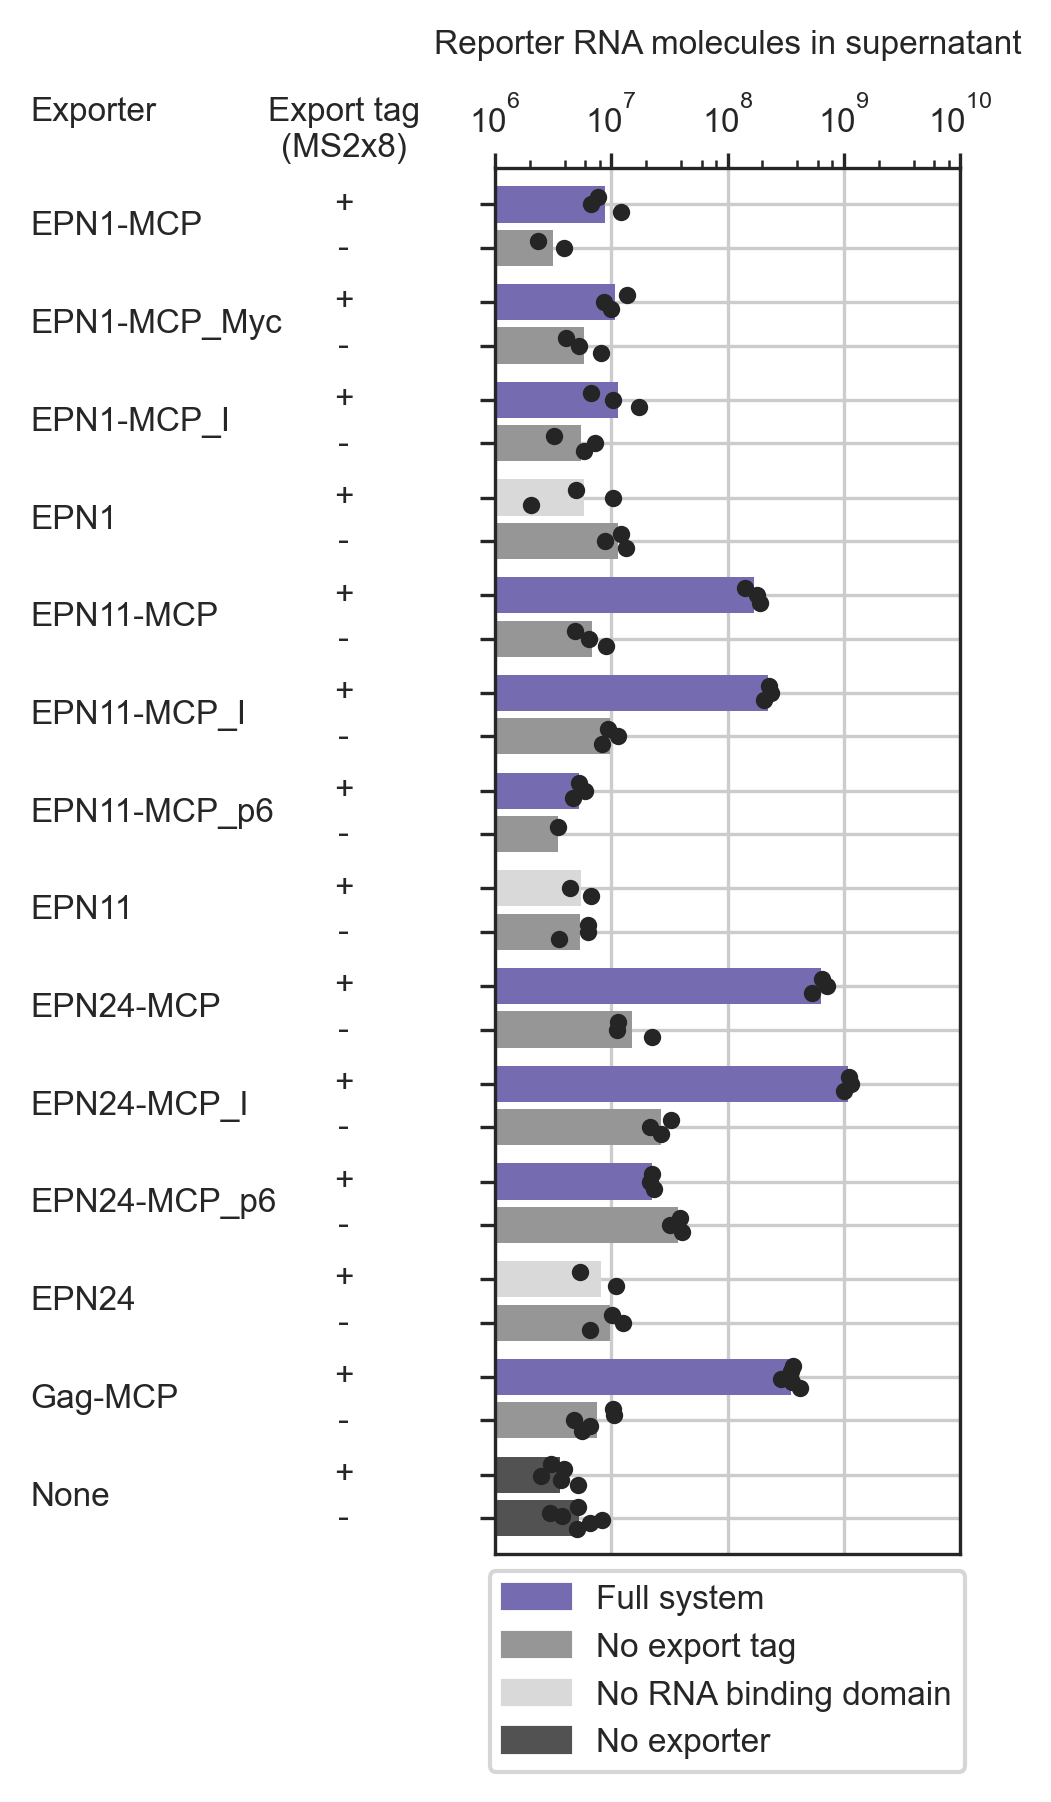

In [23]:
# Make simple plot that shows export using best system and comparison with wild-type Gag

field = "RNA molecules"

sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(2,6))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e6, 1e10)

# Get x positions of bars (numerical data)
x = summary_subset[field]

# Set colors
color = [column_to_color[col] for col in columns_ordered]

# Specify custom y positions to group bars
y_origin = 0
y_offset = 0.3
y_space = 0.75

y = [y_origin+1*y_offset, y_origin+3*y_offset,
     y_origin+3*y_offset+y_space, y_origin+5*y_offset+y_space,
     y_origin+5*y_offset+2*y_space, y_origin+7*y_offset+2*y_space,
     y_origin+7*y_offset+3*y_space, y_origin+9*y_offset+3*y_space,
     y_origin+9*y_offset+4*y_space, y_origin+11*y_offset+4*y_space,
     y_origin+11*y_offset+5*y_space, y_origin+13*y_offset+5*y_space,
     y_origin+13*y_offset+6*y_space, y_origin+15*y_offset+6*y_space,
     y_origin+15*y_offset+7*y_space, y_origin+17*y_offset+7*y_space,
     y_origin+17*y_offset+8*y_space, y_origin+19*y_offset+8*y_space,
     y_origin+19*y_offset+9*y_space, y_origin+21*y_offset+9*y_space,

     y_origin+21*y_offset+10*y_space, y_origin+23*y_offset+10*y_space,
     y_origin+23*y_offset+11*y_space, y_origin+25*y_offset+11*y_space,
     y_origin+25*y_offset+12*y_space, y_origin+27*y_offset+12*y_space,
     y_origin+27*y_offset+13*y_space, y_origin+29*y_offset+13*y_space]
     
# Plot bars showing summary of replicates (mean)
ax.barh(y=y, width=x, color=color, height=0.5, linewidth=0)

# Plot individual points as swarm (sort columns appropriately)
sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")
x_swarm = data["RNA molecules"]
y_swarm = np.array([y[rank] for rank in data["rank"]])
y_offset3 = np.array([-0.1, 0, 0.1])  # jitter offsets to avoid overlaps
y_offset5 = np.array([-0.15, -0.075, 0, 0.075, 0.15])
y_offset6 = np.array([-0.15, -0.075, -0.025, 0.025, 0.075, 0.15])
y_swarm_offset = y_swarm + np.concatenate([np.tile(y_offset3, 24), np.tile(y_offset6, 1), np.tile(y_offset5, 1), np.tile(y_offset6, 2)])
ax.scatter(x_swarm, y_swarm_offset, color="#252525", s=10, zorder=10)

# Set axis aesthetics
ax.set_ylim(y[0]-0.5, y[-1]+0.5)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA molecules in supernatant", labelpad=10)
ax.set_ylabel("")
ax.set_yticks(y)
ax.grid(True)

# Set xticks
# xticks = [1e6, 1e7, 1e8, 1e9, 1e10]
# ax.set_xticks(xticks)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set custom tick labels
yticklabels = ""
ax.set_yticklabels(yticklabels, ha="left")

# Set custom tick text annotations
labels_exporter = [column_to_exporter[col] for col in columns_ordered][::2]
y_labels_exporter = [(y[0] + y[1])/2, 
                     (y[2] + y[3])/2, 
                     (y[4] + y[5])/2,
                     (y[6] + y[7])/2,
                     (y[8] + y[9])/2, 
                     (y[10] + y[11])/2,
                     (y[12] + y[13])/2,
                     (y[14] + y[15])/2,
                     (y[16] + y[17])/2,
                     (y[18] + y[19])/2,
                     (y[20] + y[21])/2,
                     (y[22] + y[23])/2,
                     (y[24] + y[25])/2,
                     (y[26] + y[27])/2]

x_pos_text_exporter = 1.0e2
x_pos_text_export_tag = 5e4

for label, y_pos in zip(labels_exporter, y_labels_exporter):
    ax.text(x_pos_text_exporter, y_pos, label, ha="left", va="center", size=FONTSIZE)

labels_reporter = [column_to_export_tag_plus_or_minus[col] for col in columns_ordered]
for label, y_pos in zip(labels_reporter, y):
    ax.text(x_pos_text_export_tag, y_pos, label, ha="center", va="center", size=FONTSIZE)

# Set tick annotation column labels
ax.text(x_pos_text_exporter, y[0]-1.5, "Exporter", ha="left", va="top", size=FONTSIZE)
ax.text(x_pos_text_export_tag, y[0]-1.5, "Export tag\n(MS2x8)", ha="center", va="top", size=FONTSIZE)

# Add legend
color_legend = [color_exporter_engineered,
                color_no_packaging_signal,
                color_no_RBD,
                color_no_exporter]
label_legend = ["Full system",
                "No export tag",
                "No RNA binding domain",
                "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]
ax.legend([patches[0], patches[1], patches[2], patches[3]], label_legend,
          handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
          loc="upper center", bbox_to_anchor=(0.5, 0))

save_figure(fig, "barplot_EPN_screen")